## Testing an Autoencoder

In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

Using TensorFlow backend.


Separate encoded model 

In [2]:

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

Decoder Model 

In [3]:
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

Compiling model for mninst

In [4]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['accuracy'])

Preparing data for Trining: Data from MNIST

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [6]:
checkpoint_file = 'fc_weights.hdf5'
checkpointer = ModelCheckpoint(filepath=checkpoint_file, verbose=0, save_best_only=True)
history = autoencoder.fit(x_train, x_train,
                nb_epoch=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),callbacks=[checkpointer])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s - loss: 0.3680 - acc: 0.0103 - val_loss: 0.2723 - val_acc: 0.0159
Epoch 2/10
60000/60000 [==============================] - 7s - loss: 0.2649 - acc: 0.0171 - val_loss: 0.2540 - val_acc: 0.0171
Epoch 3/10
60000/60000 [==============================] - 7s - loss: 0.2438 - acc: 0.0177 - val_loss: 0.2311 - val_acc: 0.0170
Epoch 4/10
60000/60000 [==============================] - 7s - loss: 0.2236 - acc: 0.0163 - val_loss: 0.2136 - val_acc: 0.0156
Epoch 5/10
60000/60000 [==============================] - 7s - loss: 0.2087 - acc: 0.0152 - val_loss: 0.2010 - val_acc: 0.0136
Epoch 6/10
60000/60000 [==============================] - 7s - loss: 0.1976 - acc: 0.0130 - val_loss: 0.1913 - val_acc: 0.0127
Epoch 7/10
60000/60000 [==============================] - 6s - loss: 0.1889 - acc: 0.0119 - val_loss: 0.1837 - val_acc: 0.0131
Epoch 8/10
60000/60000 [==============================] - 6s 

In [7]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

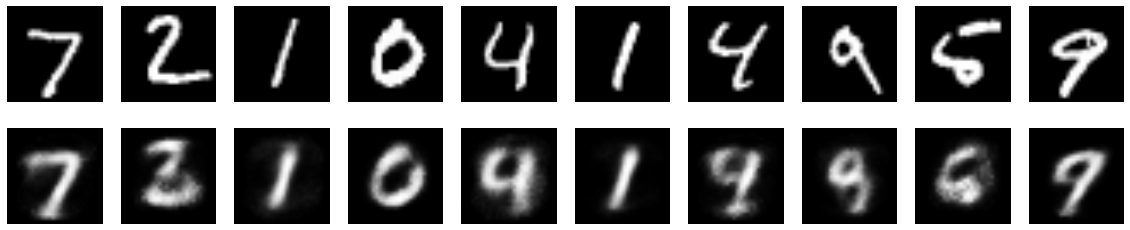

In [8]:
# inline plots
%matplotlib inline
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
encoded_inputs = encoder.predict(x_train)
from sklearn import cluster
clf = cluster.KMeans(init='k-means++', n_clusters=10)
clf.fit(encoded_inputs)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [10]:
clf.labels_

array([6, 0, 2, ..., 1, 2, 1], dtype=int32)

Try PCA to see how good it might be

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
#all components
#pca = PCA()

newdataPCA = pca.fit_transform(encoded_inputs)  # concatenates vectors row by row

print (pca.explained_variance_ratio_)

[ 0.29400075  0.14635179  0.12876699]


Try TSNE for representing data


In [ ]:
from sklearn.manifold import TSNE
model_tsne = TSNE(n_components=2, random_state=0)
Y = model_tsne.fit_transform(encoded_inputs)
print('TSNE')
print(type(Y))
import pandas as pd
import seaborn as sns

data = {"x": [], "y": [], "cluster": []}
for i in range(len(x_train)):
    data["x"].append(Y[i][0])
    data["y"].append(Y[i][1])
    data["cluster"].append(clf.labels[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df,
           fit_reg=False, size=10,
           hue="cluster", legend=True)
plt.show()